In [1]:
# Uncomment and run to reload libs
# import importlib
# import utils
# importlib.reload(utils)
# import utils.miscellaneous
# importlib.reload(utils.miscellaneous)
# import utils.reader
# importlib.reload(utils.reader)


from datetime import timedelta
from collections import defaultdict
from multiprocessing import Pool, cpu_count, Manager, managers

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
from matplotlib.colors import rgb2hex

from utils import (
    logging,
    AVERAGE_PERIOD,
    MIN_TOTAL_NUM,
    FIXATION_PERCENTAGE,
    FIXATION_DAYS_THESHOLD,
    FIXATION_LINKAGE_FILE,
    MUTATION_TREND_PLOT,
    FIXATION_LABEL_PLOT,
    ALL_MUT_SETS_FILE,
    ALL_AA_COMBO_FILE,
)
from utils.reader import MutationPerSeqReader
from utils.miscellaneous import aa_per_seq


In [2]:
mut_reader: MutationPerSeqReader = MutationPerSeqReader()
mut_reader.area_filter()
mut_reader.protein_filter()
df_area_protein: pd.DataFrame = mut_reader.get_data()


In [3]:
total_num: pd.DataFrame = df_area_protein[["Accession", "Date"]].drop_duplicates()
total_num = total_num["Date"].value_counts().rename("Total").to_frame()
all_date_range = pd.date_range(
    start=min(total_num.index),
    end=max(total_num.index),
)
total_num = total_num.reindex(all_date_range)
total_num = total_num.fillna(0)
total_num["Avg_total"] = total_num["Total"].rolling(AVERAGE_PERIOD).mean()
total_num = total_num.dropna()


In [4]:
all_fixed_mut = {}
mut_group: pd.DataFrame
for mut, mut_group in df_area_protein.groupby("Mutation", sort=False):
    logging.info(mut)
    mut_num = []
    mut_counts: dict = mut_group["Date"].value_counts().to_dict()
    for c_date in all_date_range:
        mut_num.append({
            "Mutation": mut,
            "Date": c_date,
            "Num": mut_counts.get(c_date, 0)
        })
    mut_num = pd.DataFrame.from_records(mut_num)
    mut_num = mut_num.sort_values("Date")
    mut_num["Avg_num"] = mut_num["Num"].rolling(AVERAGE_PERIOD).mean()
    mut_num = mut_num.dropna()
    mut_num = pd.merge(
        mut_num,
        total_num,
        left_on="Date",
        right_index=True,
    )
    mut_num["Percentage"] = mut_num["Avg_num"] / mut_num["Avg_total"]
    if sum((mut_num["Avg_total"] > MIN_TOTAL_NUM) &
           (mut_num["Percentage"] > FIXATION_PERCENTAGE)) > FIXATION_DAYS_THESHOLD:
        all_fixed_mut[mut] = mut_num


In [5]:
x_pos = pd.date_range(
    start=min(mut_num["Date"]),
    end=max(mut_num["Date"]),
)

# Select mutation for target protein
rows = [i for i in all_fixed_mut.keys()]
# Matrix of mutation daily percentage
mut_percentage_mat = []

fig, axes = plt.subplots(
    nrows=len(rows),
    ncols=2,
    sharex=True,
    sharey="col",
    figsize=(10, 2 * len(rows))
)

for mut, (ax, ax2) in zip(rows, axes):
    mut_daily: pd.DataFrame = all_fixed_mut[mut]

    mut_percentage_mat.append(mut_daily[["Date", "Percentage", "Mutation"]])

    ax.fill_between(mut_daily["Date"], 0, mut_daily["Total"], label="Background", facecolor='#AFDAE8')
    ax.fill_between(mut_daily["Date"], 0, mut_daily["Num"], label="Mutation", facecolor='#F7E15F')
    ax.tick_params(axis='x', labelrotation=60)
    ax.set_xlim([x_pos[1], x_pos[-1]])
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax.set_ylabel(mut)

    # Show trajectory of the mutations (emphasize the current)
    for mut2 in rows:
        if mut2 == mut:
            ax2.plot_date(
                mut_daily["Date"],
                mut_daily["Percentage"],
                ".-",
            )
        else:
            ax2.plot_date(
                all_fixed_mut[mut2]["Date"],
                all_fixed_mut[mut2]["Percentage"],
                "-",
                alpha=0.5
            )
    ax2.tick_params(axis='x', labelrotation=60)
    ax2.set_xlim([x_pos[1], x_pos[-1]])
    ax2.xaxis.set_major_formatter(DateFormatter('%b %Y'))

mut_percentage_mat: pd.DataFrame = pd.concat(mut_percentage_mat)
mut_percentage_mat = mut_percentage_mat.pivot(index="Date", columns="Mutation", values="Percentage")
mut_percentage_mat = mut_percentage_mat.fillna(0)

# plt.show()
plt.savefig(MUTATION_TREND_PLOT, bbox_inches="tight")
plt.close()


In [6]:
mut_state_count = defaultdict(list)
for d, mut_state in (mut_percentage_mat > FIXATION_PERCENTAGE).iterrows():
    mut_state = tuple(mut_percentage_mat.columns.values[mut_state])
    if len(mut_state):
        mut_state_count[mut_state].append(d)

labels = []
for mut_state, c_dates in mut_state_count.items():
    if len(c_dates) > 30:
        labels = [
            *labels,
            *[{"label": ", ".join(mut_state), "date": d}
                for d in c_dates]
        ]
labels = pd.DataFrame.from_records(labels, index="date")
# labels = labels.reset_index(level=0)

labels.to_csv(FIXATION_LINKAGE_FILE, index=True)
logging.info(f"{FIXATION_LINKAGE_FILE} saved")


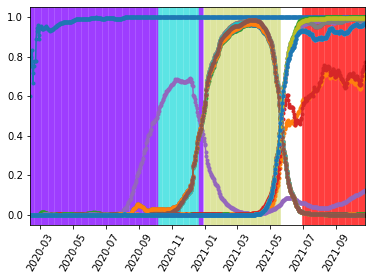

In [7]:
n_labels = labels["label"].nunique()
logging.info(f"{n_labels} clusters")

cluster_colors = {
    i: rgb2hex(c[:3])
    for i, c in zip(labels["label"].unique(),
                    cm.rainbow(np.linspace(0, 1, n_labels)))
}

for mut in rows:
    _ = plt.plot(
        mut_percentage_mat[mut].index.values,
        mut_percentage_mat[mut].values,
        ".-",
        label=mut
    )

xlim_l, xlim_r = plt.xlim([x_pos[1], x_pos[-1]])
plt.tick_params(axis='x', labelrotation=60)

for d, l in labels["label"].items():
    plt.axvspan(d, d + timedelta(days=1),
                alpha=0.3, color=cluster_colors[l])

plt.show()
plt.savefig(FIXATION_LABEL_PLOT, bbox_inches="tight")
plt.close()


In [8]:
mut_reader.stop_codon_filter()
mut_reader.insertion_filter()
mut_reader.deletion_filter()
df: pd.DataFrame = mut_reader.get_data()


In [9]:
# All unique unmutated sites (reference sequence) for all mutated sits
pos_info = df[["Protein", "From", "Pos"]]
pos_info = pos_info.drop_duplicates().reset_index(drop=True)
pos_info = pos_info.rename(columns={"From": "To"})
logging.info(f"{len(pos_info)} mutated pos")


In [10]:
# Get mutations for each ac and unique sequences (mutated and unmutated sites)
manager: managers.SyncManager
with Manager() as manager:
    all_aa_combo = manager.dict()
    logging.info("Start multi-processing")
    with Pool(cpu_count()) as p:
        # 'all_aa_combo' is the amino acid per site combination
        all_mut_sets = p.starmap(
            func=aa_per_seq,
            iterable=((*i, pos_info, all_aa_combo)
                      for i in df.groupby("Accession", sort=False))
        )
        logging.info(f"{len(all_aa_combo)} mutation combination")

        all_mut_sets = pd.DataFrame.from_records(all_mut_sets)
        all_mut_sets.to_csv(ALL_MUT_SETS_FILE, index=False)
        logging.info(f"{ALL_MUT_SETS_FILE} saved!")

    all_aa_combo: pd.DataFrame = pd.concat(list(all_aa_combo.values()))
    all_aa_combo = all_aa_combo.reset_index(drop=True)
    logging.info(f"{len(all_aa_combo)} data points")
    all_aa_combo.to_csv(ALL_AA_COMBO_FILE, index=False)
    logging.info(f"{ALL_AA_COMBO_FILE} saved!")
